In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('ticks',
              rc={'axes.facecolor': (0, 0, 0, 0)})
sns.set_context('talk')

from matplotlib import rcParams, colors, cm
rcParams['font.family'] = 'sans-serif'
rcParams['figure.dpi'] = 150

In [2]:
!wget --quiet -O escapecalculator.py https://raw.githubusercontent.com/jbloomlab/SARS2-RBD-escape-calc/main/escapecalculator.py

In [3]:
import math
import random
import numpy as np
import pandas as pd
import networkx as nx
from scipy import stats
# local import
import escapecalculator

In [4]:
# RBD mutations

# based on 10.1038/s41467-022-34506-z
AFFINITY = [501, 498]
ESCAPE = [417, 446, 484, 493, 496, 505,
          # these are extra from 10.1126/science.abo7896
          447, 449, 506, 406]
# data from the escape calculator
# commit 5ebb88e
esc = escapecalculator.EscapeCalculator()
esc = esc.escape_per_site([])[['site', 'original_escape']]
ESCAPE = sorted(set(ESCAPE).union(esc.loc[esc['original_escape'] > 0.1]['site'].values))
# based on outbreak.info
MOI = [484, 18, 417, 439, 452, 477, 494, 501, 681]

In [5]:
def read_mi(fname, name='all'):
    a = pd.read_csv(fname, sep='\t')

    # filtering
    #
    # 1. end of the genome
    # 2. same gene and same codon
    # 3. different gene and too close
    #
    a = a[((a['pos_source'] <= 29674) & (a['pos_target'] <= 29674)) &
          (((a['gene_source'] == a['gene_target']) &
            (a['feature_codon_source'] != a['feature_codon_target']) &
            (a['codon_distance'] > 1)) |
           ((a['gene_source'] != a['gene_target']) &
            (a['distance'] > 1)))]
    
    a['name'] = name
    
    return a

In [6]:
def enrichment(a, save_gml=None):
    g = nx.Graph()
    for p0, p1 in a[(a['gene_source'] == 'S') &
                    (a['gene_target'] == 'S') &
                       (a['pos_source'] > 22519) &
                       (a['pos_source'] < 23186) &
                       (a['pos_target'] > 22519) &
                       (a['pos_target'] < 23186)][['feature_codon_source',
                                                'feature_codon_target']].values:
        g.add_edge(int(p0), int(p1))

    for node in g.nodes:
        if node in AFFINITY:
            ntype = 'affinity'
        elif node in ESCAPE:
            ntype = 'escape'
        elif node in MOI:
            ntype = 'MOI/MOC'
        else:
            ntype = 'other'
        g.nodes[node]['type'] = ntype

    if save_gml is not None:
        nx.write_gml(g, save_gml)
    
    random.seed(100)

    # Simulate if enriched compared to random
    relevant = set(ESCAPE).union(AFFINITY).union(MOI)

    RBD_LENGTH = 540 - 319 + 1

    res = []

    # randomization #1: any position in the RBD
    # randomization #2: same positions as in the original graph
    rgraphs1 = []
    rgraphs2 = []
    for _ in range(1000):
        n_nodes = len(g.nodes)
        n_edges = len(g.edges)
        r = nx.Graph()
        nodes = list(range(319, 541))
        while len(r.edges) < n_edges:
            n1 = random.choice(nodes)
            n2 = random.choice(nodes)
            if n1 != n2 and abs(n1 - n2) > 1:
                r.add_edge(n1, n2)
        rgraphs1.append(r)
        node_mapping = dict(zip(g.nodes(),
                            sorted(g.nodes(), key=lambda k: random.random())))
        r = nx.relabel_nodes(g, node_mapping)
        # remove connections between subsequent nodes
        # change them to another random edge
        adj = [(x, y) for x, y in r.edges
               if abs(x - y) == 1]
        if len(adj) > 1:
            orig = len(r.edges)
            nodes = list(r.nodes)
            r.remove_edges_from(adj)
            while len(r.edges) < orig:
                n1 = random.choice(nodes)
                n2 = random.choice(nodes)
                if n1 != n2 and abs(n1 - n2) > 1:
                    r.add_edge(n1, n2)
        #
        rgraphs2.append(r)
    
    for i, cg in enumerate([g] + rgraphs1):
        all_possible = math.factorial(RBD_LENGTH) / (math.factorial(2) * math.factorial(RBD_LENGTH - 2))
        int_rel = len([(x, y) for x, y in cg.edges if x in relevant and y in relevant])
        int_not = len(cg.edges) - int_rel
        all_possible_rel = math.factorial(len(relevant)) / (math.factorial(2) * math.factorial(len(relevant) - 2))
        not_int_rel = all_possible_rel - int_rel
        not_int_not_rel = all_possible - not_int_rel - int_not - int_rel
    
        table = [[int_rel, not_int_rel],
                 [int_not, not_int_not_rel]]
        odds_ratio, pvalue = stats.fisher_exact(table,
                                                alternative='greater')
        
        if i == 0:
            gtype = 'original'
        else:
            gtype = 'random'
        
        res.append((gtype, odds_ratio, pvalue, 'any_positions'))
    
    # for i, cg in enumerate([g] + rgraphs2):
    #     all_possible = math.factorial(len(cg.nodes)) / (math.factorial(2) * math.factorial(len(cg.nodes) - 2))
    #     int_rel = len([(x, y) for x, y in cg.edges if x in relevant and y in relevant])
    #     int_not = len(cg.edges) - int_rel
    #     all_possible_rel = math.factorial(len(relevant)) / (math.factorial(2) * math.factorial(len(relevant) - 2))
    #     not_int_rel = all_possible_rel - int_rel
    #     not_int_not_rel = all_possible - not_int_rel - int_not - int_rel
    
    #     table = [[int_rel, not_int_rel],
    #              [int_not, not_int_not_rel]]
    #     print(table, all_possible)
    #     odds_ratio, pvalue = stats.fisher_exact(table,
    #                                             alternative='greater')
        
    #     if i == 0:
    #         gtype = 'original'
    #     else:
    #         gtype = 'random'
        
    #     res.append((gtype, odds_ratio, pvalue, 'fixed_positions'))
    
    df = pd.DataFrame(res,
                      columns=['type', 'odds-ratio', 'p-value', 'randomization'])

    return df

In [7]:
df = []
for name, idir in zip(['all-notime', 1_000, 10_000,
                       100_000, 1_000_000],
                      ['../out/'] +
                      ['../out/subsets-notime/'] * 4):
    df.append(read_mi(f'{idir}{name}/mi_annotated.tsv.gz', name))
df = pd.concat(df)

In [8]:
df.groupby('name')['pos_source'].count()

name
1000          63260
10000          3036
100000          782
1000000         478
all-notime      474
Name: pos_source, dtype: int64

In [9]:
count = df.groupby(['name', 'outlier'])['pos_source'].count().reset_index()

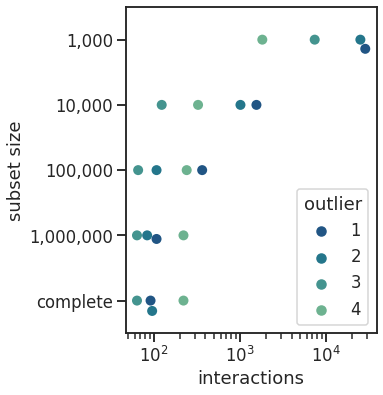

In [10]:
plt.figure(figsize=(4.5, 6))

sns.swarmplot(data=count,
              x='pos_source',
              y='name',
              hue='outlier',
              size=10,
              palette=sns.color_palette('crest_r', 4))

plt.yticks(range(5),
           ['1,000',
            '10,000',
            '100,000',
            '1,000,000',
            'complete'])

plt.legend(facecolor='w',
           title='outlier')

plt.xlabel('interactions')
plt.ylabel('subset size')

plt.xscale('log')

plt.savefig('subsets_1.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('subsets_1.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

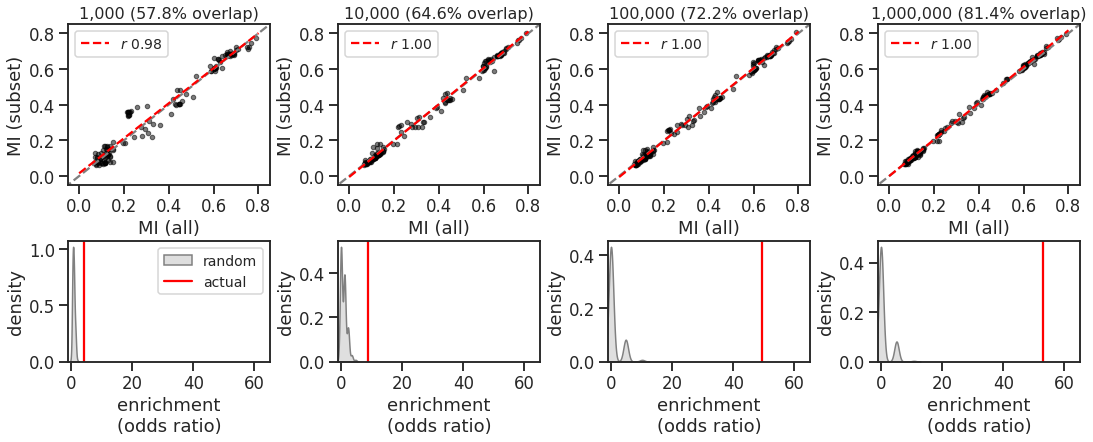

In [11]:
fig, axes = plt.subplots(2, 4,
                         figsize=(15, 6),
                         constrained_layout=True,
                         gridspec_kw = {'height_ratios':[1, 0.75]})

a = df[df['name'] == 'all-notime'].set_index(['pos_source', 'pos_target'])
for ax, subset in zip(axes.flatten(), 
                      [1_000,
                       10_000,
                       100_000,
                       1_000_000]):
    s = df[df['name'] == subset].set_index(['pos_source', 'pos_target'])
    
    idx = a.index.intersection(s.index)

    av = a.loc[idx]['mi']
    sv = s.loc[idx]['mi']
    
    ax.plot(av,
            sv,
            'k.',
            alpha=0.3,
            rasterized=True)
    ax.plot([-1, 1], [-1, 1],
            '--',
            color='grey')
    
    lr = stats.linregress(av, sv)
    
    ax.plot([0, 0.8],
            [lr.intercept,
             lr.slope * 0.8 + lr.intercept],
            'r--',
            label=f'$r$ {lr.rvalue:.2f}')
    
    ax.legend(facecolor='w', fontsize=14)
    
    ax.set_xlim(-0.05, 0.85)
    ax.set_ylim(-0.05, 0.85)
    ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8])
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8])
    
    ax.set_ylabel('MI (subset)')
    ax.set_xlabel('MI (all)')
    
    ax.set_title(f'{subset:,} ({av.shape[0] * 100 / a.shape[0]:.1f}% overlap)',
                 fontsize=16)

for ax, subset in zip(axes.flatten()[4:], 
                      [1_000,
                       10_000,
                       100_000,
                       1_000_000]):
    s = df[df['name'] == subset]
    
    o = enrichment(s)
    
    sns.kdeplot(o[(o['type'] != 'original') &
                  (o['randomization'] == 'any_positions')]['odds-ratio'],
                bw_adjust=1.5,
                color='grey', label='random',
                fill=True,
                ax=ax)
    
    ax.axvline(o[(o['type'] == 'original') &
                 (o['randomization'] == 'any_positions')]['odds-ratio'].values,
            color='r',
            label='actual')
    
    ax.set_xlim(-1, 65)
    ax.set_xticks([0, 20, 40, 60])
    
    ax.set_ylabel('density')
    ax.set_xlabel('enrichment\n(odds ratio)')
    if subset == 1_000:
        ax.legend(facecolor='w', fontsize=14)
    # ax.set_xscale('log')

plt.savefig('subsets_2.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('subsets_2.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

In [12]:
df = df[df['outlier'] > 2].copy()

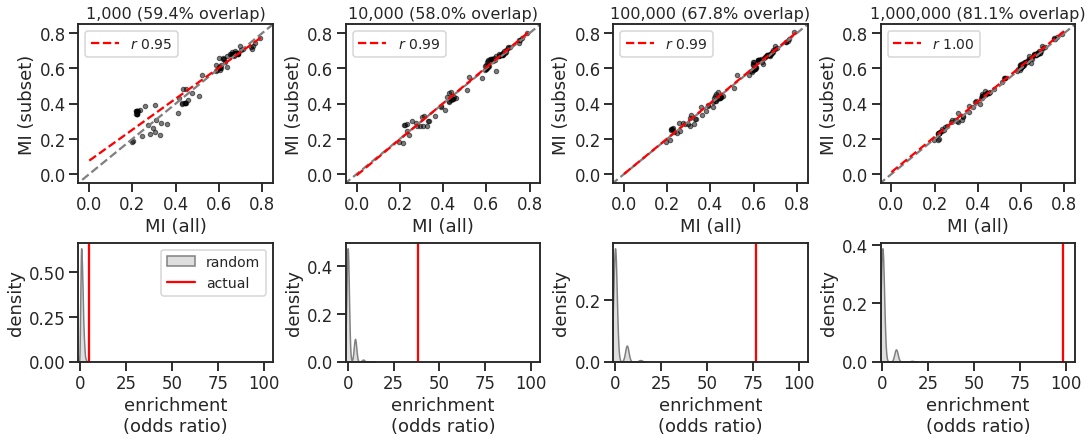

In [13]:
fig, axes = plt.subplots(2, 4,
                         figsize=(15, 6),
                         constrained_layout=True,
                         gridspec_kw = {'height_ratios':[1, 0.75]})

a = df[df['name'] == 'all-notime'].set_index(['pos_source', 'pos_target'])
for ax, subset in zip(axes.flatten(), 
                      [1_000,
                       10_000,
                       100_000,
                       1_000_000]):
    s = df[df['name'] == subset].set_index(['pos_source', 'pos_target'])
    
    idx = a.index.intersection(s.index)

    av = a.loc[idx]['mi']
    sv = s.loc[idx]['mi']
    
    ax.plot(av,
            sv,
            'k.',
            alpha=0.3,
            rasterized=True)
    ax.plot([-1, 1], [-1, 1],
            '--',
            color='grey')
    
    lr = stats.linregress(av, sv)
    
    ax.plot([0, 0.8],
            [lr.intercept,
             lr.slope * 0.8 + lr.intercept],
            'r--',
            label=f'$r$ {lr.rvalue:.2f}')
    
    ax.legend(facecolor='w', fontsize=14)
    
    ax.set_xlim(-0.05, 0.85)
    ax.set_ylim(-0.05, 0.85)
    ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8])
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8])
    
    ax.set_ylabel('MI (subset)')
    ax.set_xlabel('MI (all)')
    
    ax.set_title(f'{subset:,} ({av.shape[0] * 100 / a.shape[0]:.1f}% overlap)',
                 fontsize=16)

for ax, subset in zip(axes.flatten()[4:], 
                      [1_000,
                       10_000,
                       100_000,
                       1_000_000]):
    s = df[df['name'] == subset]
    
    o = enrichment(s)
    
    sns.kdeplot(o[(o['type'] != 'original') &
                  (o['randomization'] == 'any_positions')]['odds-ratio'],
                bw_adjust=1.5,
                color='grey', label='random',
                fill=True,
                ax=ax)
    
    ax.axvline(o[(o['type'] == 'original') &
                 (o['randomization'] == 'any_positions')]['odds-ratio'].values,
            color='r',
            label='actual')
    
    ax.set_xlim(-1, 105)
    ax.set_xticks([0, 25, 50, 75, 100])
    
    ax.set_ylabel('density')
    ax.set_xlabel('enrichment\n(odds ratio)')
    if subset == 1_000:
        ax.legend(facecolor='w', fontsize=14)
    # ax.set_xscale('log')

plt.savefig('subsets_3.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('subsets_3.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);